## Pipeline to extract the feature data cubes <br>
only the feature data is extracted - currently in float

We also add the COP 30 DEM and METRO data (average temperature).

In [1]:
import openeo
from extentmapping.openeo.processing import generate_master_feature_cube
from extentmapping.config import get_job_options, get_collection_options, get_advanced_options
from extentmapping.utils import laea20km_id_to_extent, reproj_bbox_to_ll, bbox_area
import os
import json

C:\Users\BUCHHORM\Anaconda3\envs\extent\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### connect to the backend

In [2]:
backend = 'cdse'

# Make connection
if backend == 'terrascope':
    connection = openeo.connect("https://openeo.vito.be").authenticate_oidc()
elif backend == 'development':
    connection = openeo.connect("https://openeo-dev.vito.be").authenticate_oidc()
elif backend == 'cdse':
    connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()
else:
    print('currently no specific connections to backends like creodias and sentinelhub are setup.')
    print('use standard entry point')
    connection = openeo.connect("https://openeo.cloud").authenticate_oidc()

Authenticated using refresh token.


### init the job, processing and collection option depending on provider and task

In [3]:
job_options = get_job_options(provider=backend, task='feature_generation')
collection_options = get_collection_options(provider=backend)
processing_options = get_advanced_options(provider=backend)

In [4]:
# just print for an overview
print(f'job_options: {job_options}')
print(f'collection_options: {collection_options}')
print(f'processing_options: {processing_options}')

job_options: {'driver-memory': '8G', 'driver-memoryOverhead': '5G', 'driver-cores': '1', 'executor-memory': '1500m', 'executor-memoryOverhead': '2500m', 'executor-cores': '1', 'max-executors': '25', 'soft-errors': 'true', 'executor-request-cores': '800m', 'executor-threads-jvm': '7', 'logging-threshold': 'info'}
collection_options: {'S2_collection': 'SENTINEL2_L2A', 'METEO_collection': None, 'S1_collection': 'SENTINEL1_GRD', 'DEM_collection': 'COPERNICUS_30'}
processing_options: {'provider': 'cdse', 's1_orbitdirection': 'DESCENDING', 'target_crs': 3035, 'resolution': 10.0, 'time_interpolation': False, 'ts_interval': 'dekad', 'SLC_masking_algo': 'mask_scl_dilation', 'optical_vi_list': ['NDVI', 'AVI', 'CIRE', 'NIRv', 'NDMI', 'NDWI', 'BLFEI', 'MNDWI', 'NDVIMNDWI', 'S2WI', 'S2REP', 'IRECI'], 'radar_vi_list': ['VHVVD', 'VHVVR', 'RVI'], 'S2_scaling': [0, 10000, 0, 1.0], 'S1_db_rescale': True, 'append': True}


### specify the space and time context

In [5]:
# the time context is given by start and end date
start = '2020-01-01'
end = '2021-01-01'   # the end is always exclusive

In [6]:
# the space context is defined as a bounding box dictionary with south,west,north,east and crs
# we take as example the AOI of Daniele's test for habitat mapping
AOI = {'east': 610240, 'south': 5689760, 'west': 600000, 'north': 5700000, 'crs': 'EPSG:32631'}
bbox_area(AOI)

area of AOI in km2: 104.8576


### we can also use the LAEA 20km grid for processing <br>
Either take directly the LAEA grid for processing, or if you have an AOI then we intersect and process all LAEA-20km tiles

In [7]:
import importlib.resources as importlib_resources
import geopandas as gpd
import extentmapping.resources

# get the LAEA-20km grid saved as EPSG:4326 vector
grid = importlib_resources.files(extentmapping.resources).joinpath('LAEA-20km.gpkg')
with grid.open('rb') as f:
    gdf = gpd.read_file(f, encoding='utf-8')
    
# reproject the AOI bbox to Lat/lon
AOI_ll = reproj_bbox_to_ll(AOI)

# spaitial intersect and retrieve the tile_ID's of the LAEA-20km grid
lTiles = gdf[gdf.intersects(AOI_ll)].name.unique().tolist()

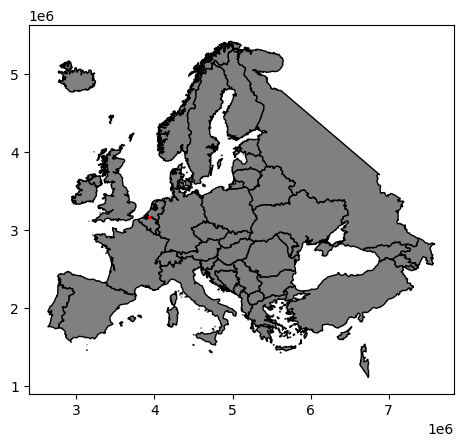

In [8]:
# just some visualization of the LAEA tiles to process
import requests
import matplotlib.pyplot as plt
url = 'https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson'
response = requests.get(url)
data = response.json()
europe = gpd.GeoDataFrame.from_features(data).set_crs(epsg=4326, allow_override=True).to_crs(3035)
fig,ax = plt.subplots()
europe.plot(color='grey', edgecolor='black', ax=ax)
gdf[gdf.name.isin(lTiles)].to_crs(3035).plot(color='red',ax=ax)
plt.show()

### run over the Tiles and process

In [9]:
test_num = 15

# define the output folder root
out_root = os.path.normpath(r'\\netapp03.vgt.vito.be\people_vol1\tests\openeo\feature_generation')
out_root = os.path.join(out_root, f'test_v{str(test_num)}')
os.makedirs(out_root, exist_ok=True)

In [10]:
# for test we only take the first tile
lTiles = [lTiles[0]]

for current_tile in lTiles:
    print(f'**** processing LAEA tile: {current_tile}')
    # get the bbox for this tile for processing
    processing_extent = laea20km_id_to_extent(current_tile)
    bbox_area(processing_extent)
    
    # define the job to get input data
    feature_cube = generate_master_feature_cube(connection,
                                                processing_extent,
                                                start,
                                                end,
                                                **collection_options,
                                                **processing_options)
    
    # run it
    try:
        job = feature_cube.execute_batch(title=f'master feature generation for tile {current_tile} - run {str(test_num)}',
                                         description='generation of features for classification',
                                         out_format='GTiff',
                                         job_options=job_options)
                
        # Get the results and save to output file
        results = job.get_results()
        
        # make sub-folder
        sub_folder = os.path.join(out_root, str(current_tile))
        os.makedirs(sub_folder, exist_ok=True)
        outputfile = os.path.join(sub_folder, f'master_features_cube_openeo_{current_tile}_v{str(test_num)}.tif')
        results.download_file(outputfile)
        # get metadata and job info
        with open(outputfile.replace('.tif','.json'), "w") as outfile:
            json.dump(results.get_metadata(),outfile)
        with open(outputfile.replace('.tif','-job.json'), "w") as outfile:
            json.dump(job.describe_job(),outfile)

    except Exception as e:
        print(e)

**** processing LAEA tile: E392N314
area of AOI in km2: 400.0
0:00:00 Job 'j-231129c3533b47c5ae602293288507de': send 'start'
0:00:14 Job 'j-231129c3533b47c5ae602293288507de': created (progress N/A)
0:00:19 Job 'j-231129c3533b47c5ae602293288507de': created (progress N/A)
0:00:26 Job 'j-231129c3533b47c5ae602293288507de': created (progress N/A)
0:00:34 Job 'j-231129c3533b47c5ae602293288507de': created (progress N/A)
0:00:45 Job 'j-231129c3533b47c5ae602293288507de': created (progress N/A)
0:00:57 Job 'j-231129c3533b47c5ae602293288507de': running (progress N/A)
0:01:13 Job 'j-231129c3533b47c5ae602293288507de': running (progress N/A)
0:01:32 Job 'j-231129c3533b47c5ae602293288507de': running (progress N/A)
0:01:57 Job 'j-231129c3533b47c5ae602293288507de': running (progress N/A)
0:02:28 Job 'j-231129c3533b47c5ae602293288507de': running (progress N/A)
0:03:05 Job 'j-231129c3533b47c5ae602293288507de': running (progress N/A)
0:03:52 Job 'j-231129c3533b47c5ae602293288507de': running (progress N/A)